In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

# 去背神器 (pytorch)

支援python 版本: 3.5以上  
支援pytorch版本 : 1.4以上

對於攝影師或者是專業美工來說，去背可以說是日常進行的家常便飯，但是也正因為這個作業太頻繁也太瑣碎，所以正好成為人工智能來幫我們解決問題的好題材，除了照片修圖摳圖之外，像是直播實時更換背景，或者是可以避開人身體的彈幕，這些應用都需要將人體給分割出來。本實作將會利用谷歌的deeplab v3+來介紹如何開發去背模型。所謂的去除背景，其實目標是在預測一個逐像素的二元遮罩(binary mask)，其中，0表示是人體以外的部分，1表示是人體，在這邊服裝以及髮型也被認為是人體的一部分，髮絲級的人體分割還會涉及到matting的技術，就暫時不再本實作中討論 

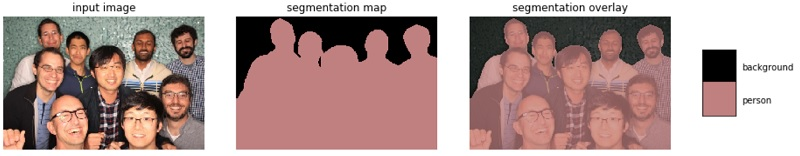

In [2]:
display.Image('../images/background_removal.jpg')

In [3]:
import glob
import os
import cv2
os.environ['TRIDENT_BACKEND'] = 'pytorch'

#!pip install tridentx --upgrade
import trident as T
from trident import *
from trident.models import efficientnet,deeplab


trident 0.7.1


Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: rgb.
Pytorch version:1.7.1+cu110.
Automatic Mixed Precision Support:True.


Opencv version:4.1.2.
Pillow version:7.1.2.


本次使用的數據集是吳恩達創辦的supervisely所發布的人體分割數據集Supervisely Person，在我開發的trident api中可以透過關鍵字"people"下載，裡面附的是將原圖稍作縮小的精簡版，已經足以用來訓練本次模型。若是各位對於原始數據感興趣，您也可以到 https://supervise.ly/ 即可下載取得圖資。

<img src="../images/supervise.png">

In [4]:
data_provider=load_examples_data('people')
data_provider.paired_transform_funcs=[RandomCenterCrop((224, 224),scale=(0.7,3.0))]
data_provider.image_transform_funcs=[
                     AddNoise(0.01),
                     RandomAdjustGamma(gamma_range=(0.6,1.5)),
                     RandomAdjustContrast(value_range=(0.6, 1.5)),
                     RandomAdjustHue(value_range=(-0.5, 0.5)),
                     Normalize(0,255),
                     Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]

archive file is already existing, donnot need download again.
extraction is finished, donnot need extract again.
get people images :5711


這是一組高解析度的人體分割數據集，裡面覆蓋的場景蠻完整的，包括了正面、遠景、化妝、局部身體...都包括其中，我認為唯一的缺點就是圖片選擇有點太過唯美，因此容易過擬合，在一般照片中會效果變差，但是這可以透過數據增強技術來克服。或者是建議可以將Pascal VOC或者是之前實作範例「街景分割」的數據中的「人」的部分提取出來混合，可以讓效果變得更好

<img src="../images/SuperviselyPerson.jpg">

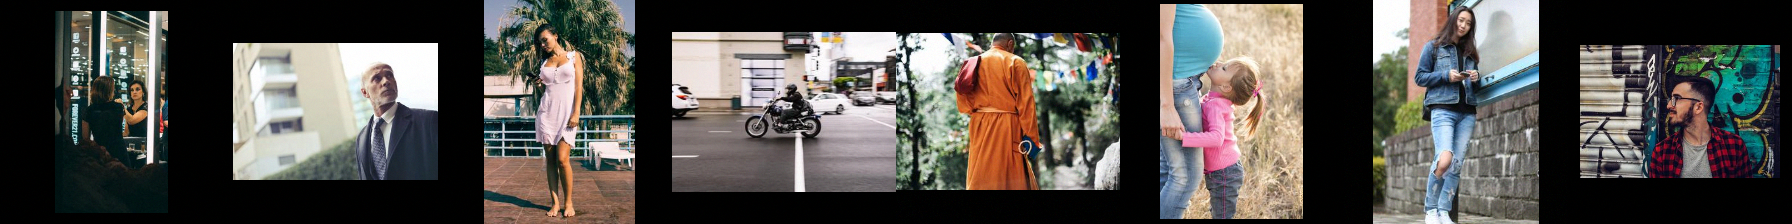

In [5]:
data_provider.preview_images()

原本deeplab論文中使用的是resnet以及mobilenet作為主骨幹，但是既然我們已經學到了更厲害的主骨幹EfficientNet(各位可以參考實作「鑑黃大師」)，權重數更少、執行更快且準確率越高，根本就是一次滿足三種願望，所以我們採用EfficientNetB0作為主骨幹。各位可以使用summary()來檢視他的模型結構。

In [6]:
backbond_net=efficientnet.EfficientNetB0(pretrained=True)
backbond_net.summary()

model file is already existing, donnot need download again.


C:\Anaconda3\envs\azuremlenv\lib\site-packages\torch\serialization.py:658: SourceChangeWarning: source code of class 'trident.layers.pytorch_layers.Dense' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Anaconda3\envs\azuremlenv\lib\site-packages\torch\serialization.py:658: SourceChangeWarning: source code of class 'trident.layers.pytorch_layers.SoftMax' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


--------------------------------------------------------------------------------------------------------------------------------
                   Layer (type)                    Output Shape               Weight               Bias      Param #   FLOPS #                  
stem.conv  [Conv2d]                                [None, 32, 112, 112]       [32, 3, 3, 3]                  864  21,663,488.0  
stem.norm  [BatchNorm]                             [None, 32, 112, 112]       [32]                 [32]      64  1,191,680.0  
stem  [Conv2d_Block]                               [None, 32, 112, 112]                                      0  0.0  
block1a.0.conv  [DepthwiseConv2d]                  [None, 32, 112, 112]       [32, 1, 3, 3]                  288  7,212,800.0  
block1a.0.norm  [BatchNorm]                        [None, 32, 112, 112]       [32]                 [32]      64  1,191,680.0  
block1a.0  [DepthwiseConv2d_Block]                 [None, 32, 112, 112]                          

ImageClassificationModel(
  (inputs): TensorSpec(shape=(None, 3, 224, 224), ndim=4, name=input)
  (_outputs): { output: TensorSpec(shape=(None, 1000), ndim=2, name=output) }
  (_targets): TensorSpec(shape=(None, 1000), ndim=2, name=output)
)

<img src="../images/deeplabv3plus.png">

在Deeplab v3+中的主骨幹範圍總共將原圖下採樣4次，等於是長寬縮小1/16倍，因此要將EfficientNet裁切成適合Deeplab v3+使用的話，需要能夠找到圖像長寬縮小1/16倍的主骨幹範圍。在trident API中，會自動搜索圖像長寬縮小1/4倍(224x224縮小到56x56)以及1/16(224x224縮小到14x14)之處，來作為低層級特徵(low-level features)以及連接ASPP的高階特徵使用。對應到生成的Deeplab結構分別為backbond1.x以及backbond2.x。為了節省計算量，最後下採樣的解碼器，我使用depthwise卷積來替代標準的卷積。

In [7]:

backbond=backbond_net.model
backbond.trainable=False
deeplabv3=deeplab.DeeplabV3_plus(backbond,input_shape=(3,224,224),atrous_rates=(6,12,18,24),num_filters=256,classes=2)
deeplabv3.summary()
deeplabv3.preprocess_flow=backbond_net.preprocess_flow



5288548 parameters have set untrainable
--------------------------------------------------------------------------------------------------------------------------------
                   Layer (type)                    Output Shape               Weight               Bias      Param #   FLOPS #                  
backbond1.stem.conv  [Conv2d]                      [None, 32, 112, 112]       [32, 3, 3, 3]                  864  21,663,488.0  
backbond1.stem.norm  [BatchNorm]                   [None, 32, 112, 112]       [32]                 [32]      64  1,191,680.0  
backbond1.stem  [Conv2d_Block]                     [None, 32, 112, 112]                                      0  0.0  
backbond1.1.0.conv  [DepthwiseConv2d]              [None, 32, 112, 112]       [32, 1, 3, 3]                  288  7,212,800.0  
backbond1.1.0.norm  [BatchNorm]                    [None, 32, 112, 112]       [32]                 [32]      64  1,191,680.0  
backbond1.1.0  [DepthwiseConv2d_Block]             [None,

所有基於預訓練骨幹的模型都最好先將大部分的預訓練區域權重凍結，然後再依照訓練狀況逐步開放，因此我們將整個deeplab模型設為可訓練，然後將主骨幹部分設為不可訓練，但是backbond2的最後一層(backbond2.0.7)是開放學習的。

In [8]:
#deeplabv3.load_model('Models/deeplab_seg.pth.tar')

deeplabv3.model.backbond2[7].trainable=True


208572 parameters have set trainable


在損失函數的選取部分，我們採用複合的損失函數策略。Dice loss跟F1 Score概念有點像(各位可以參考實作:鑑黃大師)，它是權衡了準確率與召回率的一個指標，它著重在各個類別層級的像素預測吻合程度。至於大家熟悉的交叉熵，則是像素層級來判斷預測機率與實際答案之差異。兩種損失混和在一起可以獲得較全面的收斂效果。其中Dice loss的好處在於收斂非常快，但是它畢竟是類別層級，所以到了訓練中後期會比較後繼無力，這時候搭配像素層級的交叉熵，正好兩者互補。

此外，也推薦使用曠視在UnitBox這篇論文所提出的IOU Loss (Iouloss=-ln(iou))，他利用對數後取負值將原本非連續不可微分的IOU轉化成連續可微分的損失函數，它直接針對IOU做優化，所以對於會發生收斂停滯這類問題時也非常有用，但由於它本身的形式，當IOU很小時它的數值會過大且不穩定，所以比較適合與其他損失函數一起搭配使用。此外實務上，如果類別間比例非常不均衡，建議還可以加入Focal Loss，來解決比例不均衡的問題。   

至於在評價函數上，我們加入了像素正確率(正確預測像素數/非背景值得像素總數)以及iou(預測值與實際值交集/預測值與實際值聯集)，兩者分子的意義是一樣的，iou的分母會大一點，所以整體數值應該會略低於像素正確率。

至於學習速率方面，請不要設得太大，建議設定為1e-4上下，否則很容易發生損失函數收斂很快然後又反彈升高的狀況。使用較低的學習速率訓練，可以獲得較穩定的結果。訓練時如果有loss持續下降但是IOU沒有顯著回升的狀況，也請保持點耐心，這是正常現象，模型要訓練到一個臨界點後，IOU才會有明顯的變化。

In [9]:


deeplabv3.with_optimizer(optimizer='Ranger',lr=1e-3,betas=(0.9, 0.999))\
    .with_loss(DiceLoss)\
    .with_loss(CrossEntropyLoss(),loss_weight=4)\
    .with_loss(IoULoss,0.5,start_epoch=1)\
    .with_loss(FocalLoss,start_epoch=3)\
    .with_metric(pixel_accuracy,name='pixel_accuracy')\
    .with_metric(iou,name='iou')\
    .with_regularizer('l2',reg_weight=1e-6)\
    .with_constraint('min_max_norm')\
    .with_learning_rate_scheduler(reduce_lr_on_plateau,monitor='iou',mode='max',factor=0.5,patience=1,cooldown=1,threshold=5e-5,warmup=0)\
    .with_model_save_path('Models/deeplab_seg.pth')\
    .with_callbacks(SegTileImageCallback(batch_inteval=100,reverse_image_transform=data_provider.reverse_image_transform,background=(255,128,255)))\
    .with_automatic_mixed_precision_training()


deeplabv3.summary()

#在模型中設定
#with_optimizer 設定優化器為Ranger
#with_loss(DiceLoss) 加入Dice loss損失函數(類別層級)
#with_loss(CrossEntropyLoss,2)加入交叉熵作為損失函數(像素層級)
#with_loss(IouLoss,1)加入iou損失作為損失函數(類別層級) 直接針對iou優化

#建議訓練的後半段可以加入
#with_loss(FocalLoss,2)加入FocalLoss作為損失函數(像素層級)解決類別不均衡問題

#with_metric(pixel_accuracy) 加入像素正確率metrics
#with_metric(iou,name='iou') 加入iou作為metrics
#with_regularizer('l2')\ 加入l2正則
#with_constraint('max_min_norm')\ 加入max_min_norm權重正則
#with_learning_rate_scheduler(reduce_lr_on_plateau) 加入reduce_lr_on_plateau學習率變化原則(指標不再變動時，學習率下降)
#with_model_save_path('Models/deeplab_seg.pth') 設定模型存檔路徑
#with_callbacks 加入SegTileImageCallback來繪製比較用的tile images

DiceLoss( output, target) -> DiceLoss 
CrossEntropyLoss( output, target) -> CrossEntropyLoss 
IoULoss( output, target) -> IoULoss 
FocalLoss( output, target) -> FocalLoss 
pixel_accuracy( output, target) -> pixel_accuracy 
iou( output, target) -> iou 
Automatic Mixed Precision:Turn On.
--------------------------------------------------------------------------------------------------------------------------------
                   Layer (type)                    Output Shape               Weight               Bias      Param #   FLOPS #                  
backbond1.stem.conv  [Conv2d]                      [None, 32, 112, 112]       [32, 3, 3, 3]                  864  21,663,488.0  
backbond1.stem.norm  [BatchNorm]                   [None, 32, 112, 112]       [32]                 [32]      64  1,191,680.0  
backbond1.stem  [Conv2d_Block]                     [None, 32, 112, 112]                                      0  0.0  
backbond1.1.0.conv  [DepthwiseConv2d]              [None, 32, 112

backbond2.2.2.excite  [Conv2d]                     [None, 240, 1, 1]          [240, 10, 1, 1]      [240]     2,640  5,039.0  
backbond2.2.2  [SqueezeExcite]                     [None, 240, 14, 14]                                       0  0.0  
backbond2.2.3.conv  [Conv2d]                       [None, 80, 14, 14]         [80, 240, 1, 1]                19,200  7,526,204.0  
backbond2.2.3.norm  [BatchNorm]                    [None, 80, 14, 14]         [80]                 [80]      160  46,844.0  
backbond2.2.3  [Conv2d_Block]                      [None, 80, 14, 14]                                        0  0.0  
backbond2.2.4  [Identity]                          [None, 80, 14, 14]                                        0  0.0  
backbond2.3.Identity  [Identity]                   [None, 80, 14, 14]                                        0  0.0  
backbond2.3.branch2.0.conv  [Conv2d]               [None, 480, 14, 14]        [480, 80, 1, 1]                38,400  15,052,604.0  
backbond2.3.br

aspp.0.aspp_dilation1.norm  [BatchNorm]            [None, 256, 14, 14]        [256]                [256]     512  150,332.0  
aspp.0.aspp_dilation1  [Conv2d_Block]              [None, 256, 14, 14]                                       0  0.0  
aspp.0.aspp_dilation2.conv  [Conv2d]               [None, 256, 14, 14]        [256, 112, 3, 3]               258,048  101,154,620.0  
aspp.0.aspp_dilation2.norm  [BatchNorm]            [None, 256, 14, 14]        [256]                [256]     512  150,332.0  
aspp.0.aspp_dilation2  [Conv2d_Block]              [None, 256, 14, 14]                                       0  0.0  
aspp.0.aspp_dilation3.conv  [Conv2d]               [None, 256, 14, 14]        [256, 112, 3, 3]               258,048  101,154,620.0  
aspp.0.aspp_dilation3.norm  [BatchNorm]            [None, 256, 14, 14]        [256]                [256]     512  150,332.0  
aspp.0.aspp_dilation3  [Conv2d_Block]              [None, 256, 14, 14]                                       0  0.0  


ImageSegmentationModel(
  (inputs): TensorSpec(shape=(None, 3, 224, 224), ndim=4, name=input)
  (_outputs): TensorSpec(shape=(None, 2, 224, 224), ndim=4, name=output)
  (_targets): TensorSpec(shape=(None, 2, 224, 224), ndim=4, name=target)
  (_losses): <trident.optims.pytorch_losses.DiceLoss object at 0x000001E791EC32E8>
  (_losses): <trident.optims.pytorch_losses.CrossEntropyLoss object at 0x000001E791EC3400>
  (_losses): IoULoss()
  (_losses): <trident.optims.pytorch_losses.FocalLoss object at 0x000001E791EC3518>
  (_metrics): functools.partial(<function pixel_accuracy at 0x000001E7EBE77730>)
  (_metrics): functools.partial(<function iou at 0x000001E7EBE77950>)
  (loss_weights): 1.0
  (loss_weights): 1.0
  (loss_weights): 0.5
  (loss_weights): 1.0
  (_regs): functools.partial(<function l2_reg at 0x000001E7EAD15B70>, reg_weight=1e-06)
  (_constraints): functools.partial(<function min_max_norm at 0x000001E7EAD158C8>)
)

In [10]:
plan=TrainingPlan()\
    .add_training_item(deeplabv3,name='deeplab')\
    .with_data_loader(data_provider)\
    .repeat_epochs(30)\
    .with_batch_size(16)\
    .print_progress_scheduling(20,unit='batch')\
    .display_loss_metric_curve_scheduling(frequency=100,unit='batch',imshow=True)\
    .save_model_scheduling(100,unit='batch')\
    #.with_tensorboard()\

#add_training_item加入要訓練的模型
#with_data_loader加入數據提供者
#repeat_epochs設定要執行的epoch數量
#within_minibatch_size設定minibatch_size
#print_progress_scheduling設定列印進度的頻率
#display_loss_metric_curve_scheduling設定顯示損失函數曲線的頻率
#save_model_scheduling設定存檔的頻率

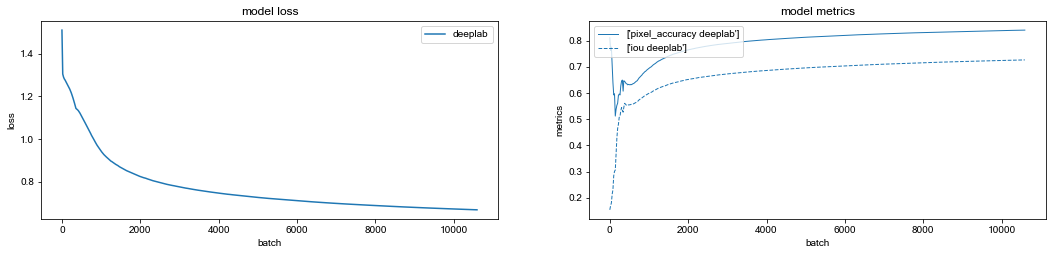

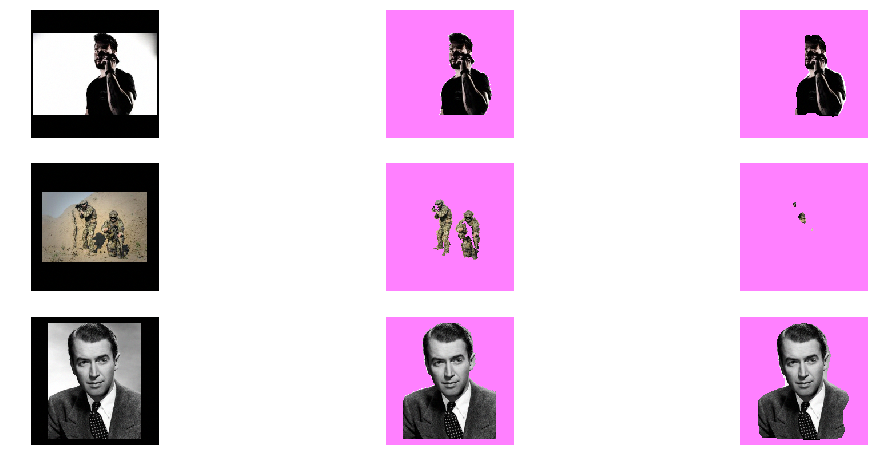

deeplab      Step: 25s822ms | Loss: 66.919% | pixel_accuracy: 83.913% ,iou: 72.536%  | learning rate: 1.000e-03  | epoch: 29  ( 260/357 )
deeplab      Step: 20s721ms | Loss: 66.906% | pixel_accuracy: 83.919% ,iou: 72.543%  | learning rate: 1.000e-03  | epoch: 29  ( 280/357 )
deeplab      Step: 21s80ms  | Loss: 66.894% | pixel_accuracy: 83.925% ,iou: 72.550%  | learning rate: 1.000e-03  | epoch: 29  ( 300/357 )
deeplab      Step: 21s176ms | Loss: 66.881% | pixel_accuracy: 83.930% ,iou: 72.556%  | learning rate: 1.000e-03  | epoch: 29  ( 320/357 )
deeplab      Step: 21s206ms | Loss: 66.868% | pixel_accuracy: 83.936% ,iou: 72.563%  | learning rate: 1.000e-03  | epoch: 29  ( 340/357 )


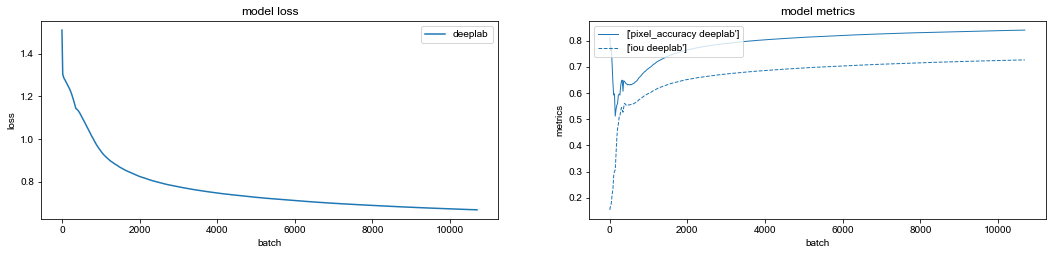

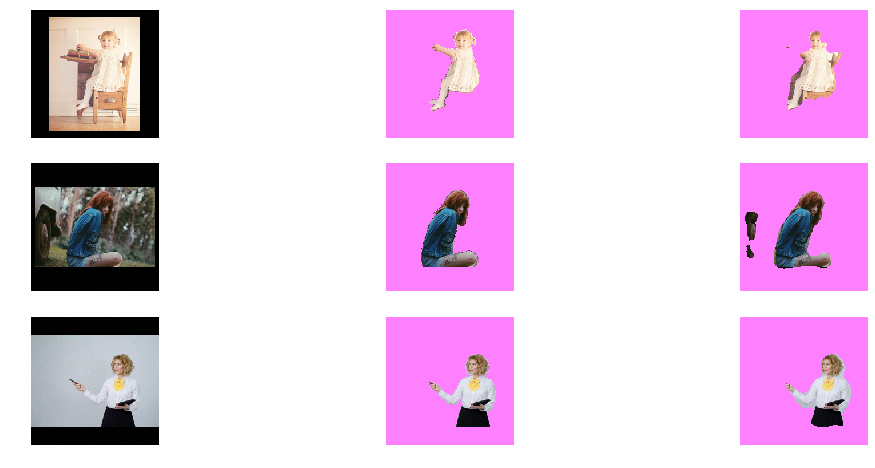

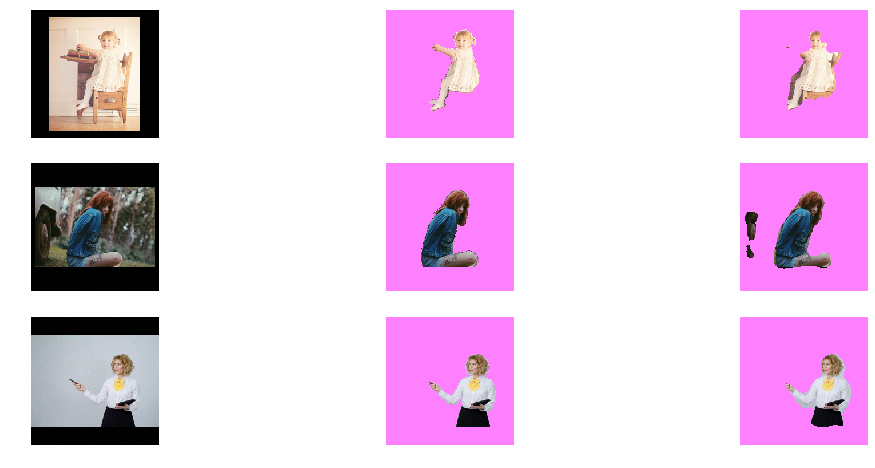

In [11]:
plan.start_now()